# Utilities

## Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from numpy.polynomial import Polynomial
from scipy.linalg import toeplitz, solve
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from scipy.stats import genlogistic, weibull_min

## Utility functions

In [2]:
def genlogistic_cdf(arr, c, loc, scale):
    return genlogistic.cdf(arr, c=c, loc=loc, scale=scale)


def weibull_sf(arr, c, loc, scale):
    return weibull_min.sf(arr, c=c, loc=loc, scale=scale)


def scale_down(arr):
    k = 1
    while arr.max() // k > 1000:
        k *= 10
    return (arr / k, k)


def shift(arr):
    s = arr.min()
    return (arr - s, s)


def fit(x, y, x_eval, kind, p0=None, print_params=False, deg=1):
    """Special curve fitting function

    Args:
        x (np.array): index
        y (np.array): values to fit
        x_eval (np.array): subset of index to considered
        kind (str): type of function
        p0 (np.array, optional): Initial guess. Defaults to None.
        print_params (bool, optional): show optimial parameters for fitting. Defaults to False.
        deg (int, optional): degree for polynomial fit. Defaults to 1.

    Returns:
        np.array: fitted curve
    """
    func = {
        "genlogistic": genlogistic_cdf,
        "weibull_sf": weibull_sf,
    }
    y, k = scale_down(y)
    x, s = shift(x)
    if kind == "polynomial":
        polynom = Polynomial.fit(x, y, deg)
        res = polynom(x_eval - s)
        if print_params:
            print(polynom)
    else:
        params, _ = curve_fit(func[kind], x, y, p0)
        res = func[kind](x_eval - s, *params)
        if print_params:
            print(params)
    return res * k


def extrapolate(df, col=None, x_eval=None, kind="normal", **kwargs):
    """Extrapolate data using the previous fit function

    Args:
        df (Series or DataFrame): df containing nan values to be extrapolated
        col (str, optional): specify which column if df is a DataFrame. Defaults to None.
        x_eval (np.array, optional): subset of index to considered. Defaults to None.
        kind (str, optional): type of function. Defaults to "normal".

    Raises:
        TypeError: _description_

    Returns:
        pd.series: fitted curve over x_eval
    """
    if col:
        if isinstance(col, list):
            raise TypeError("One column at a time")
        df = df[col]
    x = df.dropna().index.values
    y = df.dropna().values
    if x_eval is None:
        x_eval = df.index.values
    res = fit(x, y, x_eval, kind, **kwargs)
    return pd.Series(res, index=x_eval)


def generate_scenario(df, target, x_eval, kind, **kwargs):
    """generate scenario by backcasting

    Args:
        df (pd.Series): base case
        target (dict): targets to used for backcasting
        x_eval (np.array): subset of index to considered
        kind (str): type of function

    Returns:
        pd.Series: fitted curve over x_eval
    """
    res = df.copy()
    for key, val in target.items():
        res.loc[key] = val
    return extrapolate(res, kind=kind, x_eval=x_eval, **kwargs)


def compute_toeplitz_sf(arr):
    """Compute the (lower triangle) Toeplitz matrix of a survival curve.

    Args:
        np.array: An array representing the survival curve.

    Returns:
        np.array: The Toeplitz matrix of the survival curve
    """
    n = len(arr)
    return toeplitz(arr) * np.tril(np.ones(shape=(n, n)))


def convert_to_df(time, sf, inflow, outflow, stock, nas):
    """Convert the different (numpy) arrays representing a stock-flow models into DataFrames.

    Args:
        time (np.array): time axis of the model.
        sf (np.array): the survival curve used for the model.
        inflow (np.array): the inflow data of the model.
        outflow (np.array): the outflow data of the model.
        stock (np.array): the stock data of the model.
        nas (np.array): The net addition to stock data of the model.

    Returns:
        pd.DataFrame: df representing 5 vectors (survival curve, inflow, outflow, nas and stock)
            with time as index
    """
    timeseries = pd.DataFrame(
        data={
            "survival_curve": sf,
            "inflow": inflow,
            "outflow": outflow,
            "stock": stock,
            "nas": nas,
        },
        index=time,
    )
    return timeseries


def variation_pct(before, after):
    """Calculate percentage variation compared to a baseline

    Args:
        before (np.array): values before (baseline)
        after (np.array): values after (scenario)

    Returns:
        np.array: variation in percentage
    """
    return (before - after) / before

## Dataset

In [3]:
# Set parameters
FILEPATH = "./mfa2_data.xlsx"
EV_TYPE = 'BEV'  # BEV  OR  PHEV
START_YEAR = 2010
END_YEAR = 2100
time_frame = np.arange(START_YEAR, END_YEAR+1, 1)

data_mobility = pd.read_excel(FILEPATH, sheet_name='mobility_stats', index_col=0, header=0)
data_iea = pd.read_excel(FILEPATH, sheet_name='ev_iea', index_col=0, header=[0,1,2,3])
data_battery = pd.read_excel(FILEPATH, sheet_name='battery_data', index_col=0, header=0, usecols='A:G')

<hr>

# Scenario parameters

## EV market share (%)

Text(0.5, 1.0, 'EV market penetration')

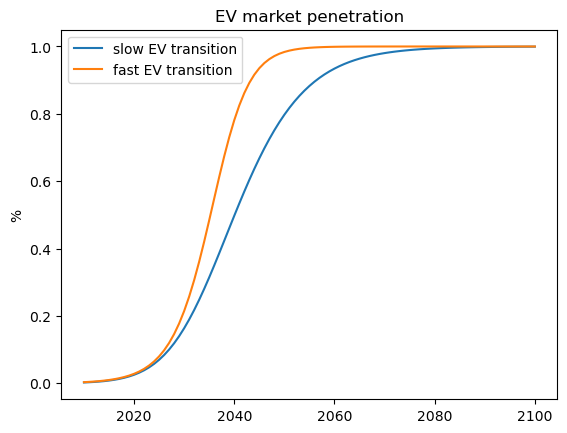

In [4]:
idx = pd.IndexSlice[("EU27", EV_TYPE, "stock", "Hist")]
ev_market_share = data_iea.loc[:, idx] / data_mobility["car_stock"]

# Define future EV market shares based on IEA scenarios
ev_share_scenario = dict()
ev_share_scenario_target = {
    "slow EV transition": {2022: 0.10, 2025: 0.11, 2030: 0.14, 2050: 0.80, 2100: 0.999},
    "fast EV transition": {2022: 0.10, 2025: 0.12, 2030: 0.20, 2050: 0.99, 2100: 0.999},
}

for scenario, target in ev_share_scenario_target.items():
    ev_share_scenario[scenario] = generate_scenario(
        ev_market_share,
        target=target,
        x_eval=time_frame,
        kind="genlogistic",
    )

# Uncomment to visualize results
fig, ax = plt.subplots()
for scenario, market_share in ev_share_scenario.items():
    ax.plot(market_share.loc[START_YEAR:END_YEAR], label=scenario)
ax.legend()
ax.set_ylabel("%")
plt.title("EV market penetration")

## Population

Text(0.5, 1.0, 'Population forecast')

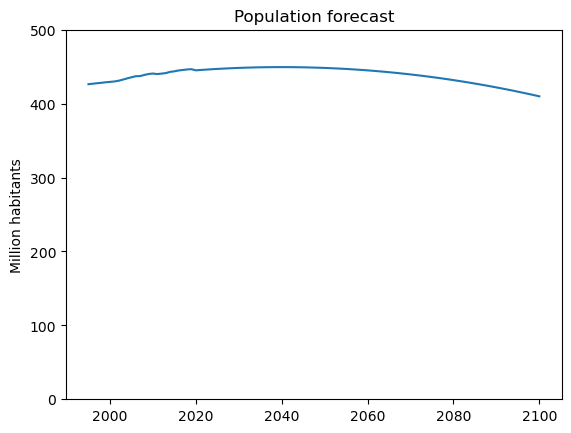

In [5]:
# Extrapolate population until 2100
population = data_mobility.loc[:, "population"]
population.loc[2020:] = extrapolate(population, kind="polynomial", deg=2).loc[2020:]

# Uncomment to visualize
fig, ax = plt.subplots()
ax.plot(population)
ax.set_ylim([0, 500e6])
ticks_y = ticker.FuncFormatter(
    lambda x, _: "{0:g}".format(x / 1e6)
)  # Change y unit to millions
ax.yaxis.set_major_formatter(ticks_y)
ax.set_ylabel("Million habitants")
plt.title("Population forecast")

## PKM demand

Text(0.5, 1.0, 'PKM demand')

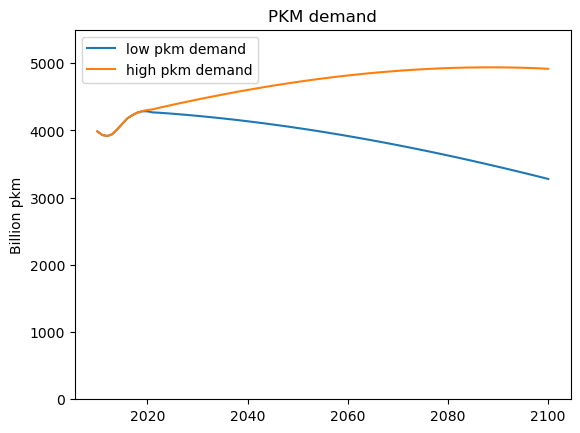

In [6]:
pkm_per_hab = data_mobility.loc[:, "pkm_car_per_hab"]

pkm_scenario = dict()
pkm_per_hab_scenario_target = {
    "low pkm demand": {END_YEAR: 8_000},
    "high pkm demand": {END_YEAR: 12_000},
}

for scenario, target_per_hab in pkm_per_hab_scenario_target.items():
    pkm_per_hab_scenario = pkm_per_hab.copy()
    # start extrapolate pkm/cap from 2020 because of outlier (covid)
    n = 2020
    pkm_per_hab_scenario[n] = np.nan
    pkm_per_hab_scenario.loc[n:] = generate_scenario(
        pkm_per_hab_scenario.loc[n - 1 :],
        target=target_per_hab,
        x_eval=pkm_per_hab.loc[n - 1 :].index,
        kind="polynomial",
        deg=1,
    ).loc[n:]
    # Compute total pkm demand
    pkm_scenario[scenario] = population * pkm_per_hab_scenario
    # Smoothen curve
    pkm_scenario[scenario].loc[:] = savgol_filter((pkm_scenario[scenario]).values, 5, 3)
    pkm_scenario[scenario] = pkm_scenario[scenario].loc[START_YEAR:END_YEAR]

# Uncomment to visualize results
fig, ax = plt.subplots()
for scenario, demand in pkm_scenario.items():
    ax.plot(demand, label=scenario)
ax.legend()
ax.set_ylim([0, 5.5e12])
ticks_y = ticker.FuncFormatter(lambda x, _: "{0:g}".format(x / 1e9))  # Change y unit
ax.yaxis.set_major_formatter(ticks_y)
ax.set_ylabel("Billion pkm")
plt.title("PKM demand")

## Vehicle lifetime: shared vs private vehicle

Text(0.5, 1.0, 'EV survival curve')

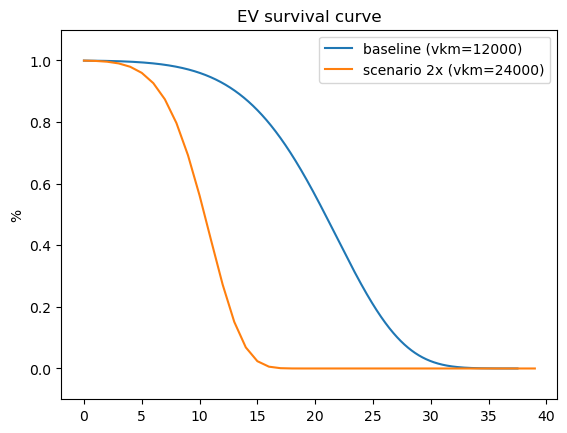

In [7]:
def baseline_ev_sf(vkm):
    """Compute baseline survival curve

    Args:
        vkm (float): average number of kilometer driven by a (private) car in 1 year

    Returns:
        np.array: survival curve
    """
    lifetime_car_km = pd.Series(np.nan, index=np.arange(0, 450_000, 50))
    # Assumptions about car lifetime (in km):
    lifetime_car_km.loc[:20_000] = 0.999
    lifetime_car_km.loc[160_000] = 0.90
    lifetime_car_km.loc[250_000] = 0.5
    lifetime_car_km.loc[400_000:] = 0.001
    lifetime_car_years = lifetime_car_km
    lifetime_car_years.index = lifetime_car_km.index / vkm
    return extrapolate(lifetime_car_years, kind="weibull_sf", p0=[3, 0.5, 3])


def scenario_ev_sf(sf, x_eval, ratio):
    """Compute scenario survival curve. If a vehicle drives n times more, its lifetime is n times shorter.

    Args:
        sf (np.array): baseline survival curve
        x_eval (np.array): subset of index to be considered
        ratio (float): = new_vkm / vkm_avg

    Returns:
        np.array: scenario survival curve
    """
    x_eval = x_eval - x_eval[0]
    res = np.zeros(x_eval.shape)
    MASK = x_eval * ratio < sf.index[-1]
    idx_in = np.searchsorted(sf.index, x_eval[MASK] * ratio) + 1
    res[MASK] = sf.iloc[idx_in].values
    return res


# Example
vkm_private = 12_000
vkm_shared = 24_000

years = np.arange(0, 40, 1)
baseline_sf = baseline_ev_sf(vkm_private)
scenario_sf = scenario_ev_sf(baseline_sf, x_eval=years, ratio=vkm_shared / vkm_private)

# Uncomment to visualize results
fig, ax = plt.subplots()
ax.plot(baseline_sf, label=f"baseline (vkm={vkm_private})")
ax.plot(scenario_sf, label=f"scenario 2x (vkm={vkm_shared})")
ax.set_ylim([-0.1, 1.1])
ax.legend()
ax.set_ylabel("%")
plt.title("EV survival curve")


## Mobility market share: TaaS vs Private (%)

Text(0.5, 1.0, 'Mobility market share')

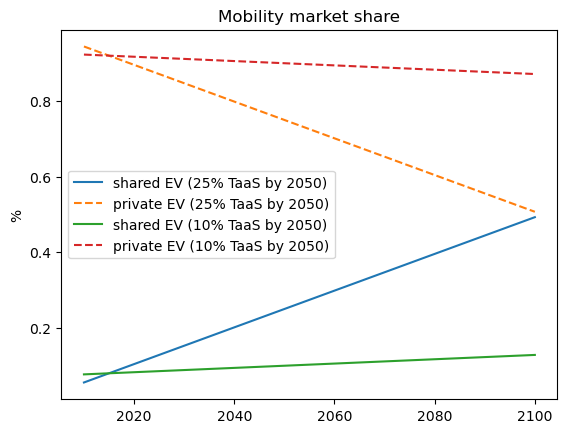

In [8]:
mobility_scenario = dict()
mobility_scenario_target = {
    "25% TaaS by 2050": {2015: 0.08, 2050: 0.25},
    "10% TaaS by 2050": {2015: 0.08, 2050: 0.10},
}

for scenario, target in mobility_scenario_target.items():
    mobility_scenario[scenario] = {}
    mobility_scenario[scenario]["shared EV"] = pd.Series(np.nan, index=time_frame)
    mobility_scenario[scenario]["shared EV"] = generate_scenario(
        mobility_scenario[scenario]["shared EV"],
        target,
        x_eval=time_frame,
        kind="polynomial",
        deg=1,
    )
    mobility_scenario[scenario]["private EV"] = (
        1 - mobility_scenario[scenario]["shared EV"]
    )


# Uncomment to visualize results
fig, ax = plt.subplots()
for scenario, market_share in mobility_scenario.items():
    ax.plot(market_share["shared EV"], label=f"shared EV ({scenario})")
    ax.plot(market_share["private EV"], "--", label=f"private EV ({scenario})")
ax.legend()
ax.set_ylabel("%")
plt.title("Mobility market share")


## Battery capacity (kWh/car)

Text(0.5, 1.0, "Vehicle's average battery capacity")

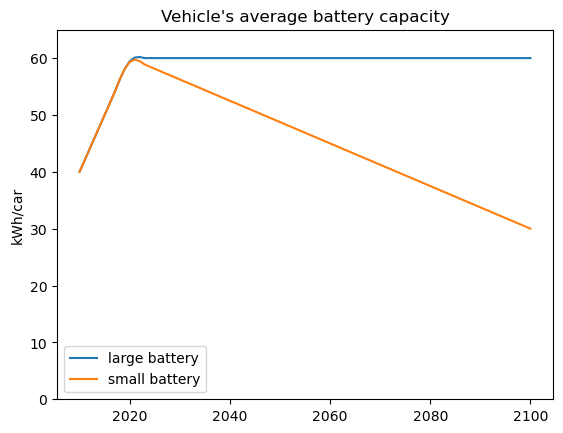

In [9]:
kWh_per_car = dict()
kWh_per_car_target = {
    "large battery": {2100: 60},
    "small battery": {2100: 30},
}

for scenario, target in kWh_per_car_target.items():
    n = 2020
    kWh_per_car[scenario] = data_battery["capacity"].copy()
    kWh_per_car[scenario].loc[:n] = np.interp(
        kWh_per_car[scenario].loc[:n].index,
        kWh_per_car[scenario].loc[np.r_[2010, n]].index,
        kWh_per_car[scenario].loc[np.r_[2010, n]].values,
    )
    kWh_per_car[scenario].loc[n:] = generate_scenario(
        kWh_per_car[scenario].loc[n:],
        target=target,
        x_eval=time_frame[time_frame >= n],
        kind="polynomial",
        deg=1,
    ).loc[n:]
    # Smoothen curve
    kWh_per_car[scenario].loc[:] = savgol_filter((kWh_per_car[scenario]).values, 7, 3)

# Uncomment to visualize results
fig, ax = plt.subplots()
for scenario, capacity in kWh_per_car.items():
    ax.plot(capacity, label=scenario)
ax.legend()
ax.set_ylim([0, 65])

ax.set_ylabel("kWh/car")
plt.title("Vehicle's average battery capacity")


## Material intensity (g/Wh)

Text(0.5, 1.0, 'Material intensity')

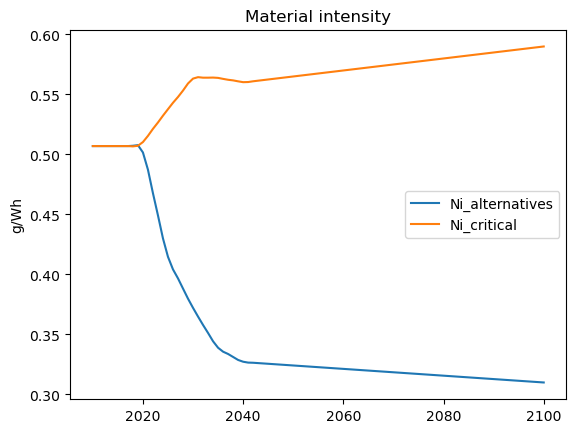

In [10]:
g_per_Wh = dict()
# Assumption: from 2040 onwards, same trends but slow progress (no forecast found in literature)
g_per_Wh_target = {
    "Ni_alternatives": {2100: 0.31},
    "Ni_critical": {2100: 0.59},
}

for scenario, target in g_per_Wh_target.items():
    g_per_Wh[scenario] = data_battery[scenario].copy()

    n = 2040
    g_per_Wh[scenario].loc[n:] = generate_scenario(
        g_per_Wh[scenario].loc[n:],
        target,
        x_eval=time_frame[time_frame >= n],
        kind="polynomial",
        deg=1,
    )
    # Smoothen curve
    g_per_Wh[scenario].loc[:] = savgol_filter((g_per_Wh[scenario]).values, 5, 3)


# Uncomment to visualize results
fig, ax = plt.subplots()
for scenario, intensity in g_per_Wh.items():
    ax.plot(intensity, label=scenario)

ax.legend()
ax.set_ylabel("g/Wh")
plt.title("Material intensity")

## Material intensity (g/car)

Text(0.5, 1.0, "Vehicle's average Nickel content")

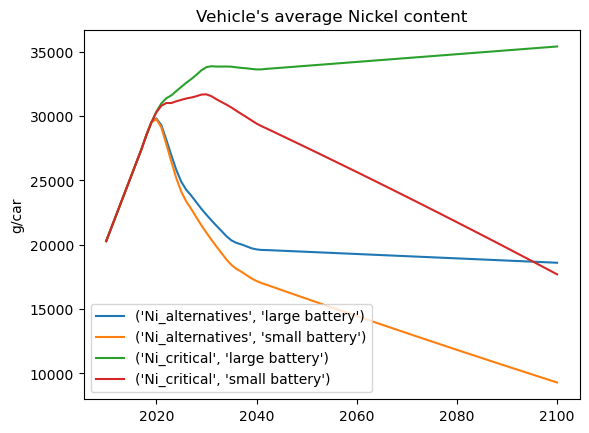

In [11]:
intensity_scenario = dict()

for scenario_intensity, intensity in g_per_Wh.items():
    for scenario_capacity, capacity in kWh_per_car.items():
        col = (scenario_intensity, scenario_capacity)
        intensity_scenario[col] = intensity * 1e3 * capacity  # g/kWh * kWh/car

# Uncomment to visualize
fig, ax = plt.subplots()
for scenario, intensity_per_car in intensity_scenario.items():
    ax.plot(intensity_per_car, label=scenario)
ax.legend()
ax.set_ylabel("g/car")
plt.title("Vehicle's average Nickel content")


<hr>

# Methodology

## Model

In [12]:
def stock_driven_model(time, stock, sf, stock_ini=0):
    """_summary_

    Args:
        time (_type_): _description_
        stock (_type_): _description_
        sf (_type_): _description_
        stock_ini (int, optional): _description_. Defaults to 0.

    Returns:
        _type_: _description_
    """
    survival_toeplitz = compute_toeplitz_sf(sf)
    inflow = solve(survival_toeplitz, stock)
    nas = np.diff(stock, prepend=stock_ini)
    outflow = inflow - nas
    return convert_to_df(time, sf, inflow, outflow, stock, nas)


def flow_driven_model(time, inflow, sf, stock_ini=0):
    """_summary_

    Args:
        time (_type_): _description_
        inflow (_type_): _description_
        sf (_type_): _description_
        stock_ini (int, optional): _description_. Defaults to 0.

    Returns:
        _type_: _description_
    """
    stock = np.convolve(inflow, sf)[: len(time)]
    nas = np.diff(stock, prepend=stock_ini)
    outflow = inflow - nas
    return convert_to_df(time, sf, inflow, outflow, stock, nas)


def model_forecasts(
    time,
    pkm_scenarios,
    ev_share_scenarios,
    mobility_scenarios,
    vkm_scenarios,
    vkm_baseline,
    occupancy,
    intensity_scenarios,
    recycling_rate,
):
    """_summary_

    Args:
        time (_type_): _description_
        pkm_scenarios (_type_): _description_
        ev_share_scenarios (_type_): _description_
        mobility_scenarios (_type_): _description_
        vkm_scenarios (_type_): _description_
        vkm_baseline (_type_): _description_
        occupancy (_type_): _description_
        intensity_scenarios (_type_): _description_
        recycling_rate (_type_): _description_

    Returns:
        _type_: _description_
    """

    ev_results = dict()
    nickel_results = dict()

    for scenario_ev_share, ev_share in ev_share_scenarios.items():
        for scenario_pkm, pkm in pkm_scenarios.items():
            for scenario_mobility, sectorial_split in mobility_scenarios.items():
                for mobility_type, mobility_share in sectorial_split.items():
                    for scenario_vkm, vkm in vkm_scenarios.items():
                        # compute EV inflows
                        if (
                            mobility_type == "private EV"
                            and scenario_vkm != "vkm baseline"
                        ) or (
                            mobility_type == "shared EV"
                            and scenario_vkm == "vkm baseline"
                        ):
                            continue
                        pkm_share = pkm * ev_share * mobility_share
                        stock = pkm_share / (vkm * occupancy)
                        sf_baseline = baseline_ev_sf(vkm_baseline)
                        sf = scenario_ev_sf(
                            sf_baseline, x_eval=time, ratio=(vkm / vkm_baseline)
                        )
                        ev_forecasts = stock_driven_model(time, stock, sf)

                        # and store results
                        idx = (
                            scenario_ev_share,
                            scenario_pkm,
                            scenario_mobility,
                            scenario_vkm,
                            mobility_type,
                        )
                        ev_results[idx] = ev_forecasts.stack()

                        for (g_per_Wh, capacity), intensity in intensity_scenarios.items():
                            # Compute Nickel inflows
                            inflow = ev_forecasts["inflow"].mul(intensity, axis=0)
                            nickel_forecast = flow_driven_model(time, inflow, sf)
                            nickel_forecast["recycling"] = (
                                nickel_forecast["outflow"] * recycling_rate
                            )
                            diff_inflow_recycl = (
                                nickel_forecast["inflow"] - nickel_forecast["recycling"]
                            )
                            nickel_forecast["virgin_inflow"] = np.where(
                                diff_inflow_recycl > 0, diff_inflow_recycl, 0
                            )
                            nickel_forecast["circular_use"] = (
                                nickel_forecast["recycling"] / nickel_forecast["inflow"]
                            )

                            # and store results
                            idx = (
                                scenario_ev_share,
                                scenario_pkm,
                                scenario_mobility,
                                scenario_vkm,
                                mobility_type,
                                g_per_Wh,
                                capacity,
                            )
                            nickel_results[idx] = nickel_forecast.stack()

    ev_results = pd.DataFrame(ev_results).unstack()
    nickel_results = pd.DataFrame(nickel_results).unstack()
    return {"EV": ev_results, "Nickel": nickel_results}

<hr>

# Results

## model run

In [13]:
# Define extra parameters needed
vkm_private = 12_000  # in km
vkm_shared = [24_000, 36_000]  # in km
vkm_shared_dct = {f"vkm ({str(round(val/vkm_private, 1))}x)": val for val in vkm_shared}
vkm_scenario = {"vkm baseline": vkm_private, **vkm_shared_dct}
occupancy = 1.5
recycling_rate = 0.9

# Run the model
results = model_forecasts(
    time=time_frame,
    pkm_scenarios=pkm_scenario,
    ev_share_scenarios=ev_share_scenario,
    mobility_scenarios=mobility_scenario,
    vkm_scenarios=vkm_scenario,
    vkm_baseline=vkm_private,
    occupancy=occupancy,
    intensity_scenarios=intensity_scenario,
    recycling_rate=recycling_rate,
)

In [14]:
results['EV']

slow EV transition                                             
         low pkm demand                                             
       25% TaaS by 2050                                             
             vkm (2.0x)                                             
              shared EV                                             
         survival_curve        inflow       outflow         stock   
2010           0.999565  1.493334e+04  6.498564e+00  1.492684e+04  \
2011           0.998555  5.576234e+03  1.750522e+01  2.048557e+04   
2012           0.996029  7.717900e+03  4.670497e+01  2.815676e+04   
2013           0.990503  1.076619e+04  1.090950e+02  3.881386e+04   
2014           0.979591  1.515884e+04  2.307197e+02  5.374198e+04   
..                  ...           ...           ...           ...   
2096           0.000000  4.212680e+06  3.992945e+06  4.405560e+07   
2097           0.000000  4.229098e+06  4.016463e+06  4.426823e+07   
2098           0.000000  4.244859e+06  4.039304e+06  4.447379e+07   
2099           0.000000  4.259962e+06  4.061473e+06  4.467228e+07   
2100           0.000000  4.274407e+06  4.082974e+06  4.486371e+07   

                                                                               
                                                                               
                                                                               
                        vkm (3.0x)                                             
                         shared EV                                             
                nas survival_curve        inflow       outflow         stock   
2010   14926.839653       0.999565  9.955559e+03  4.332376e+00  9.951226e+03  \
2011    5558.728906       0.997557  3.727434e+03  2.161509e+01  1.365705e+04   
2012    7671.194872       0.990503  5.194101e+03  7.997143e+01  1.877118e+04   
2013   10657.094947       0.971069  7.338125e+03  2.333947e+02  2.587591e+04   
2014   14928.119198       0.926400  1.052517e+04  5.730929e+02  3.582799e+04   
..              ...            ...           ...           ...           ...   
2096  219735.887384       0.000000  4.083523e+06  3.937033e+06  2.937040e+07   
2097  212635.435703       0.000000  4.100735e+06  3.958978e+06  2.951216e+07   
2098  205554.734055       0.000000  4.117304e+06  3.980267e+06  2.964919e+07   
2099  198488.703119       0.000000  4.133231e+06  4.000905e+06  2.978152e+07   
2100  191432.875536       0.000000  4.148516e+06  4.020894e+06  2.990914e+07   

                     ... fast EV transition                               
                     ...    high pkm demand                               
                     ...   10% TaaS by 2050                               
                     ...         vkm (3.0x)                               
                     ...          shared EV                               
                nas  ...     survival_curve        inflow       outflow   
2010    9951.226435  ...           0.999565  1.923822e+04  8.371928e+00  \
2011    3705.819271  ...           0.997557  4.440741e+03  4.056720e+01   
2012    5114.129915  ...           0.990503  5.841912e+03  1.471649e+02   
2013    7104.729965  ...           0.971069  7.874016e+03  4.203608e+02   
2014    9952.079465  ...           0.926400  1.089187e+04  1.007402e+03   
..              ...  ...                ...           ...           ...   
2096  146490.591589  ...           0.000000  1.598812e+06  1.551974e+06   
2097  141756.957136  ...           0.000000  1.604712e+06  1.558703e+06   
2098  137036.489370  ...           0.000000  1.610491e+06  1.565327e+06   
2099  132325.802079  ...           0.000000  1.616146e+06  1.571841e+06   
2100  127621.917024  ...           0.000000  1.621674e+06  1.578245e+06   

                                                                              
                                                                              
                                    

In [15]:
results['Nickel']

slow EV transition                                             
         low pkm demand                                             
       25% TaaS by 2050                                             
             vkm (2.0x)                                             
              shared EV                                             
        Ni_alternatives                                             
          large battery                                             
         survival_curve        inflow       outflow         stock   
2010           0.999565  3.028481e+08  1.317909e+05  3.027163e+08  \
2011           0.998555  1.187403e+08  3.574665e+05  4.210992e+08   
2012           0.996029  1.721709e+08  9.596973e+05  5.923104e+08   
2013           0.990503  2.510891e+08  2.256783e+06  8.411427e+08   
2014           0.979591  3.689055e+08  4.809601e+06  1.205239e+09   
..                  ...           ...           ...           ...   
2096           0.000000  7.864232e+10  7.526448e+10  8.262830e+11   
2097           0.000000  7.887691e+10  7.563961e+10  8.295203e+11   
2098           0.000000  7.909869e+10  7.600120e+10  8.326178e+11   
2099           0.000000  7.930770e+10  7.634937e+10  8.355761e+11   
2100           0.000000  7.950396e+10  7.668424e+10  8.383958e+11   

                                                                             
                                                                             
                                                                             
                                                                             
                                                                             
                                                                             
                                                             small battery   
               nas     recycling virgin_inflow circular_use survival_curve   
2010  3.027163e+08  1.186118e+05  3.027295e+08     0.000392       0.999565  \
2011  1.183829e+08  3.217198e+05  1.184186e+08     0.002709       0.998555   
2012  1.712112e+08  8.637276e+05  1.713072e+08     0.005017       0.996029   
2013  2.488323e+08  2.031104e+06  2.490580e+08     0.008089       0.990503   
2014  3.640959e+08  4.328641e+06  3.645769e+08     0.011734       0.979591   
..             ...           ...           ...          ...            ...   
2096  3.377836e+09  6.773803e+10  1.090428e+10     0.861343       0.000000   
2097  3.237300e+09  6.807565e+10  1.080126e+10     0.863062       0.000000   
2098  3.097497e+09  6.840108e+10  1.069762e+10     0.864756       0.000000   
2099  2.958331e+09  6.871444e+10  1.059327e+10     0.866428       0.000000   
2100  2.819717e+09  6.901582e+10  1.048814e+10     0.868080       0.000000   

                    ... fast EV transition                               
                    ...    high pkm demand                               
                    ...   10% TaaS by 2050                               
                    ...       vkm baseline                               
                    ...         private EV                               
                    ...        Ni_critical                               
                    ...      large battery               small battery   
            inflow  ...      virgin_inflow circular_use survival_curve   
2010  3.028481e+08  ...       1.399661e+10     0.000392       0.999565  \
2011  1.187403e+08  ...       3.219749e+09     0.001877       0.999185   
2012  1.721709e+08  ...       4.340745e+09     0.002468       0.998555   
2013  2.510891e+08  ...       5.906228e+09     0.003075       0.997557   
2014  3.689055e+08  ...       8.127251e+09     0.003657       0.996029   
..             ...  ...                ...          ...            ...   
2096  4.128722e+10  ...       3.659309e+10     0.905651       0.000000   
2097  4.091740e+10  ...       3.628421e+10     0.906874       0.000000   
2098  4.053808e+10  ...   

## Visualization

In [16]:

def display_results(output, variation, figsize, bbox_to_anchor, ncol):
    """Display results

    Args:
        output (str): Options are: inflow / virgin_inflow / circular_use / recycling / stock / outflow / nas
        variation (str): Options are: pct or abs
        figsize (tuple): size of displayed figures
        bbox_to_anchor (tuple): position of legend
        ncol (int): number of columns for legend
    """

    scale = 1e-9
    ylabel = "kt"

    if variation == "pct" or output == "circular_use":
        scale = 100
        ylabel = "%"

    colors_small_battery = ["#1f77b4", "#2ca02c", "#17becf", "#bcbd22"]
    colors_large_battery = ["#8c564b", "#ff7f0e", "#d62728", "#e377c2"]

    idx_best_case = pd.IndexSlice["fast EV transition", "low pkm demand", :, :, :, "Ni_alternatives", :, output]
    idx_wost_case = pd.IndexSlice["fast EV transition", "high pkm demand", :, :, :, "Ni_critical", :, output]
    idx_low_taas = pd.IndexSlice[:, :, "10% TaaS by 2050", :, :, :, :]
    idx_high_taas = pd.IndexSlice[:, :, "25% TaaS by 2050", :, :, :, :]
    idx_shared = pd.IndexSlice[:, :, :, :, "shared EV", :, :]
    idx_private = pd.IndexSlice[:, :, :, :, "private EV", :, :]
    idx_baseline = pd.IndexSlice[:, :, "10% TaaS by 2050", :, :, :, "large battery", :]
    idx_baseline_tuple = ("10% TaaS by 2050", "vkm (2.0x)", "large battery")

    fig, ax = plt.subplots(2, figsize=figsize, sharey="all")
    for i, idx_1 in enumerate((idx_wost_case, idx_best_case)):
        title = output
        title += (
            " (best case scenario)"
            if idx_1 == idx_best_case
            else " (worst case scenario)"
        )
        k = 0

        # count the number of VKM scenarios (besides baseline)
        n = results["Nickel"].columns.get_level_values(3).unique().size - 1

        if variation == "pct":
            title = "variation " + title
            before = results["Nickel"].loc[:, idx_1].loc[:, idx_baseline]
            before_val = (
                before.loc[:, idx_shared].values
                + pd.concat([before.loc[:, idx_private]] * n, axis=1).values
            )
            before = (
                pd.DataFrame(
                    before_val,
                    index=before.index,
                    columns=before.loc[:, idx_shared].columns,
                )
                .droplevel(level=[0, 1, 4, 5, 7], axis=1)
                .loc[:, pd.IndexSlice[:, "vkm (2.0x)", "large battery"]]
                .squeeze()
            )

        for j, idx_2 in enumerate((idx_low_taas, idx_high_taas)):
            res_view = results["Nickel"].loc[:, idx_1].loc[:, idx_2]
            # add private + shared cars for each VKM scenario
            res_view_val = (
                res_view.loc[:, idx_shared].values
                + pd.concat([res_view.loc[:, idx_private]] * n, axis=1).values
            )
            res_view = pd.DataFrame(
                res_view_val,
                index=res_view.index,
                columns=res_view.loc[:, idx_shared].columns,
            ).droplevel(level=[0, 1, 4, 5, 7], axis=1)

            for _, col in enumerate(res_view):
                color = (
                    colors_large_battery[k // 2]
                    if col[-1] == "large battery"
                    else colors_small_battery[k // 2]
                )
                label = (
                    "Baseline"
                    if col == idx_baseline_tuple
                    else f"{col[0]} + {col[1]} + {col[2]}"
                )
                if variation == "abs":
                    ax[i].plot(scale * res_view[col], color=color, label=label)
                elif variation == "pct":
                    after = res_view.loc[:, col]
                    change = variation_pct(before=before.values, after=after.values)
                    ax[i].plot(
                        before.index.values, scale * change, color=color, label=label
                    )
                k += 1

            ax[i].title.set_text(title)
            ax[i].yaxis.set_tick_params(labelbottom=True)
            ax[i].set_ylabel(ylabel)

    plt.legend(bbox_to_anchor=bbox_to_anchor, ncol=ncol)

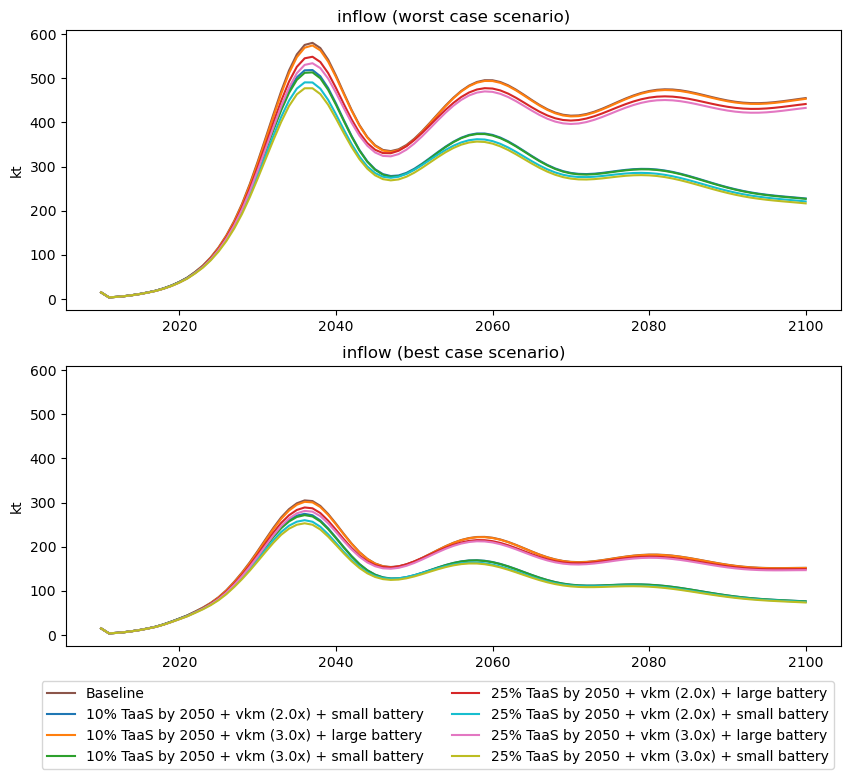

In [17]:
# output options:      inflow / virgin_inflow / circular_use / recycling / stock / outflow / nas
# variation options:   abs / pct

display_results(output='inflow', variation='abs', figsize=(10,8), bbox_to_anchor=(1, -0.1), ncol=2)

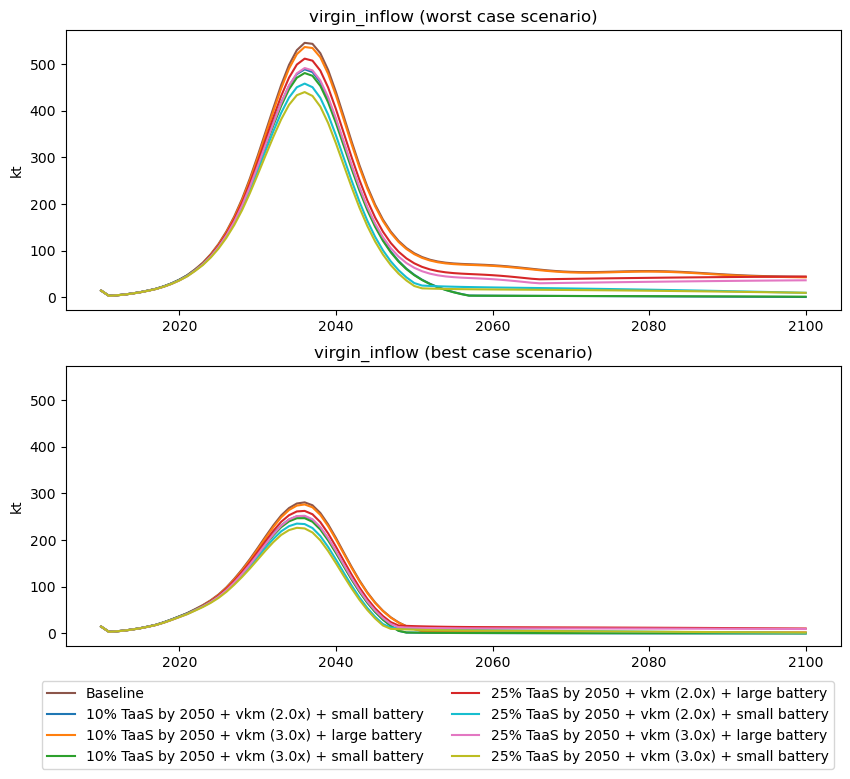

In [18]:
display_results(output='virgin_inflow', variation='abs', figsize=(10,8), bbox_to_anchor=(1, -0.1), ncol=2)

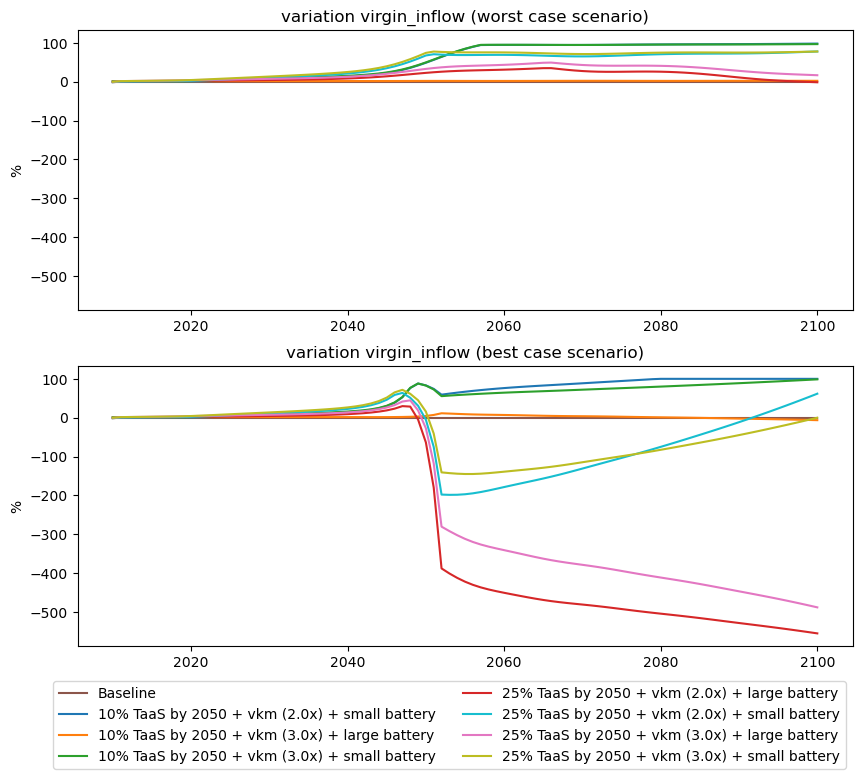

In [19]:
display_results(output='virgin_inflow', variation='pct', figsize=(10,8), bbox_to_anchor=(1, -0.1), ncol=2)

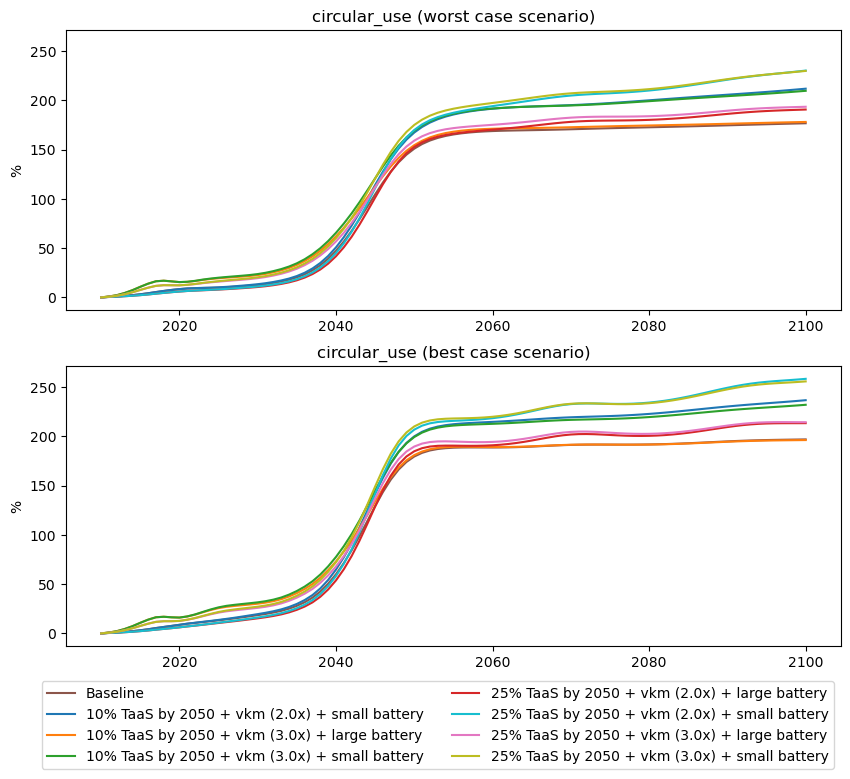

In [20]:
display_results(output='circular_use', variation='abs', figsize=(10,8), bbox_to_anchor=(1, -0.1), ncol=2)